In [1]:
import altair as alt
from bs4 import BeautifulSoup
from vega_datasets import data
import gpdvega
import geopandas
import json
import shapely
import re
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
alt.renderers.enable('notebook') # render for Jupyter Notebook

RendererRegistry.enable('notebook')

# Extract locations from XML data

In [3]:
portraitRaw = open('../portrait.xml').read()
portraitSoup = BeautifulSoup(portraitRaw)
geos = portraitSoup.find_all('geo')

In [4]:
geotext = [item.text for item in geos]

In [5]:
lineNos = [int(item.parent.parent.find_previous('lb').attrs['n']) for item in geos]

In [6]:
points = [shapely.geometry.point.Point([float(x) for x in pt.strip().split()[-1::-1]]) for pt in geotext]

In [7]:
def clean(text): 
    return re.sub('\s+', ' ', text.strip().replace('\n', ' '))

In [8]:
names = [clean(item.parent.parent.find('placename').text.strip()) for item in geos]

In [9]:
gdf = geopandas.GeoDataFrame({'name': names, 'lineNo': lineNos, 'geometry': points})

In [10]:
gdf.head()

,name,lineNo,geometry
0,Leicester Abbey,10112,POINT (-1.132563 52.640379)
1,Leicester Abbey,10116,POINT (-1.132563 52.640379)
2,Mozambique Channel,10132,POINT (41.280858 -18.615949)
3,the longest river in America,10133,POINT (-90.199404 38.627003)
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872)


# Use Natural Earth Land Vectors

From: https://www.naturalearthdata.com/downloads/50m-physical-vectors/50m-land/

In [11]:
gdf2 = geopandas.read_file('mapData/ne_50m_land.shp')

In [12]:
gdf.head()

,name,lineNo,geometry
0,Leicester Abbey,10112,POINT (-1.132563 52.640379)
1,Leicester Abbey,10116,POINT (-1.132563 52.640379)
2,Mozambique Channel,10132,POINT (41.280858 -18.615949)
3,the longest river in America,10133,POINT (-90.199404 38.627003)
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872)


In [13]:
gdf2.head()

,scalerank,featurecla,min_zoom,geometry
0,0,Land,1.5,"POLYGON ((179.99921875 -16.16855468750001, 179..."
1,0,Land,4.0,"POLYGON ((177.2341796875 -17.14707031250001, 1..."
2,0,Land,4.0,"POLYGON ((127.37265625 0.7913085937499886, 127..."
3,0,Land,3.0,POLYGON ((-81.33481445312499 24.65048828124999...
4,0,Land,4.0,"POLYGON ((-80.82939453124999 24.803662109375, ..."


# Apply Mercator projection

In [14]:
gdf.crs = {'init': 'epsg:4326'}
# gdf.crs = {'init': 'epsg:27700'}
# gdf2.crs = {'init': 'epsg:27700'}

In [15]:
gdf.crs

{'init': 'epsg:4326'}

In [16]:
mercator, britain, americas, web = (4326, 27700, 2163, 3857)
#gdf = gdf.to_crs(epsg=web)


In [17]:
gdf.crs, gdf2.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

# Convert line numbers to percentages

In [18]:
def lineToPercent(lineNo): 
    """ Convert the line number to a percentage in the narrative time of the novel,
    i.e., 0% is the beginning of the novel, 100% is the end. """
    maxLines = {1: 1848, 2: 1458, 3: 1584, 4: 922, 5: 2794}
    totalLines = sum(maxLines.values())
    chap = int(str(lineNo)[0])
    linesIntoChap = lineNo - (chap * 10000)
    preceedingLines = sum([maxLines[i] for i in range(1, chap)])
    return (preceedingLines + linesIntoChap) / totalLines

In [19]:
gdf['percentNarrative'] = gdf['lineNo'].apply(lineToPercent)

In [20]:
gdf.head()

,name,lineNo,geometry,percentNarrative
0,Leicester Abbey,10112,POINT (-1.132563 52.640379),0.013014
1,Leicester Abbey,10116,POINT (-1.132563 52.640379),0.013479
2,Mozambique Channel,10132,POINT (41.280858 -18.615949),0.015338
3,the longest river in America,10133,POINT (-90.199404 38.627003),0.015454
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872),0.017894


# Plot with Altair

In [21]:
gdf.head()

,name,lineNo,geometry,percentNarrative
0,Leicester Abbey,10112,POINT (-1.132563 52.640379),0.013014
1,Leicester Abbey,10116,POINT (-1.132563 52.640379),0.013479
2,Mozambique Channel,10132,POINT (41.280858 -18.615949),0.015338
3,the longest river in America,10133,POINT (-90.199404 38.627003),0.015454
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872),0.017894


In [22]:
gdf['longitude'] = gdf['geometry'].apply(lambda pt: pt.x)
gdf['latitude'] = gdf['geometry'].apply(lambda pt: pt.y)

In [23]:
# Slice so that it's only showing the British Isles
gdf = gdf.cx[-11:-5,50:58]
gdf2 = gdf2.cx[-11:-5,50:58]

# Reproject
gdf = gdf.to_crs(epsg=web)
gdf2 = gdf2.to_crs(epsg=web)

In [24]:
gdf.head()

,name,lineNo,geometry,percentNarrative,longitude,latitude
4,Wicklow Hotel,10154,POINT (-696932.4813543985 7046673.512596305),0.017894,-6.260651,53.342872
5,Dalkey,10228,POINT (-679699.4449431653 7034570.294774786),0.026493,-6.105844,53.277911
6,Tullabeg,10243,POINT (-938250.7621765682 6962425.840274226),0.028236,-8.428450,52.888640
7,Clongowes Wood College,10302,POINT (-744139.1812176472 7040689.935816971),0.035092,-6.684716,53.310769
8,Sallins,10303,POINT (-741970.1209395404 7029574.22250642),0.035208,-6.665231,53.251067


In [25]:
gdf2.head()

,scalerank,featurecla,min_zoom,geometry
135,0,Land,0.0,POLYGON ((-346166.6548174007 8076392.071555997...
136,0,Land,0.0,POLYGON ((-799119.5750705791 7372914.122322312...
921,0,Land,4.0,POLYGON ((-735556.5806693792 7675767.059914085...
922,0,Land,3.0,"POLYGON ((-568332.745988958 7449466.328552778,..."
923,0,Land,2.0,"POLYGON ((-643190.7551298264 7627270.82088888,..."


In [26]:
gdf2 = gdf2[gdf2.index == 136]

In [27]:
# Plot base map
base = alt.Chart(gdf2).mark_geoshape(
    fill='white',
    stroke='black'
).properties(
    width=800,
    height=800
)

points = alt.Chart(gdf).project().mark_circle().encode(
    latitude = 'latitude',
    longitude = 'longitude',
    color = 'percentNarrative',
    tooltip = 'name').properties(width=800, height=800)

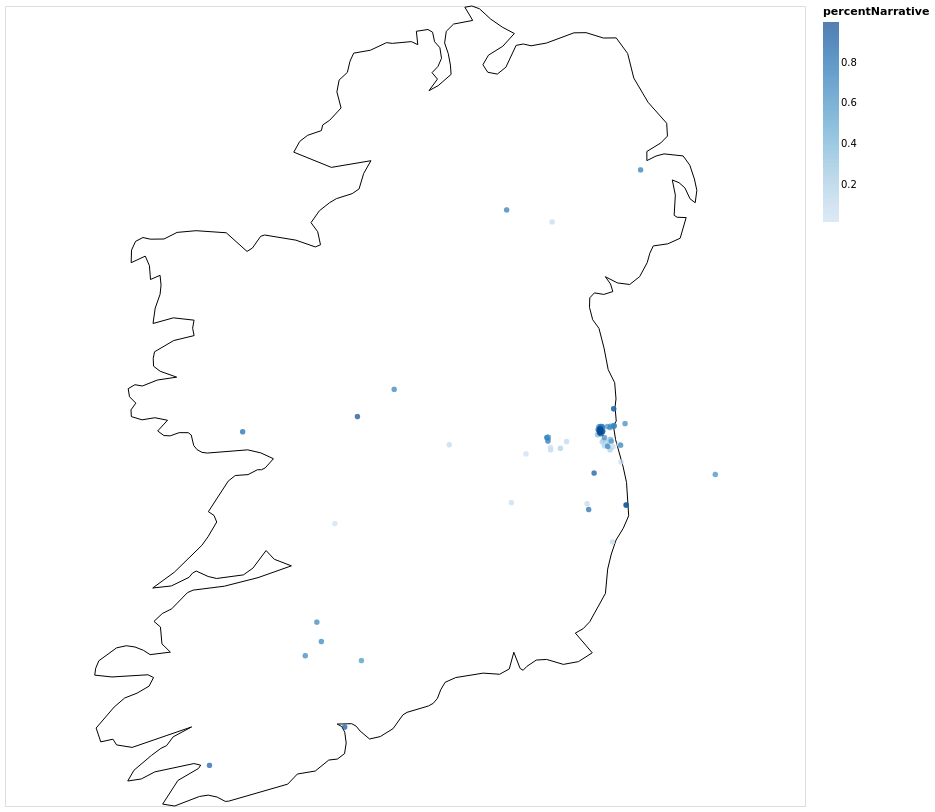

In [28]:
(base + points)